In [1]:
!pip install tensorflow==2.0.0
!pip install imutils
!pip install python-telegram-bot

import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dropout, MaxPooling2D, AveragePooling2D, Dense, Flatten, Input, Conv2D, add, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential , Model , load_model
from tensorflow.keras.preprocessing.image import load_img , img_to_array , ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from PIL import Image
import matplotlib.pyplot as plt

import cv2
from imutils import paths
import numpy as np
import os
import time
import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 86.3 MB 58 kB/s  eta 0:00:01     |████████████████████▋           | 55.5 MB 4.4 MB/s eta 0:00:07     |█████████████████████████▏      | 67.9 MB 2.5 MB/s eta 0:00:08
     |████████████████████████████████| 3.8 MB 30.7 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 3.2 MB/s eta 0:00:011
     |████████████████████████████████| 449 kB 7.0 MB/s eta 0:00:01
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7539 sha256=db912a77fa540e6d54772a84ee84484492dbc05d4104dd324f1cecf23d73ba70
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Attempting uninstall: gast
    Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.

In [2]:
print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.0.0


# **Creating class for Telegram Bot Message Updates along with Graph**

Get access_token from Telegram app: 
* Open Telegram mobile app 
* Search for "BotFather" 
* Send "/start"
* After reply from BotFather send "/newbot"
* Give name to your Bot Eg: Example_Bot
* Give username to your Bot Eg: My_Example_bot *Note: User name must end with '_bot'* 
* Done...Congratulations You have crated your own Telegram bot. Now you will get Token to access the HTTP API. Copy that Token Key.

In [3]:
import requests
import tensorflow as tf

import tensorflow.keras.utils as np_utils

access_token = 'ACCESS TOKEN' #Copy and paste Token Key given by BotFather

class botCallback(tf.keras.callbacks.Callback):
    def __init__(self,access_token):
        self.access_token = access_token
        self.ping_url = 'https://api.telegram.org/bot'+str(self.access_token)+'/getUpdates'
        self.response = requests.get(self.ping_url).json()
        #print(self.response)
        self.chat_id = self.response['result'][0]['message']['chat']['id']
        #self.chat_id = self.response['result']

    def send_message(self,message):
        #print('sending message')
        self.ping_url = 'https://api.telegram.org/bot'+str(self.access_token)+'/sendMessage?'+\
                        'chat_id='+str(self.chat_id)+\
                        '&parse_mode=Markdown'+\
                        '&text='+message
        self.response = requests.get(self.ping_url)
    
    def send_photo(self,filepath):
        imagefile= open(filepath,"rb")
        file_dict = {'photo':imagefile}
        self.ping_url = 'https://api.telegram.org/bot'+str(self.access_token)+'/sendPhoto?chat_id='+str(self.chat_id)
        self.response = requests.post(self.ping_url, files = file_dict)
        imagefile.close()

    def on_train_batch_begin(self, batch, logs=None):
        pass
    
    def on_train_batch_end(self, batch, logs=None):
        message = ' Iteration/Batch {}\n Training Accuracy : {:7.2f}\n Training Loss : {:7.2f}\n'.format(batch,logs['accuracy'],logs['loss'])
        #print(logs)
        try:
            message += ' Validation Accuracy : {:7.2f}\n Validation Loss : {:7.2f}\n'.format(logs['val_accuracy'],logs['val_loss'])
            self.send_message(message)
        except:
            pass

    def on_test_batch_begin(self, batch, logs=None):
        pass
    
    def on_test_batch_end(self, batch, logs=None):
        message = ' Iteration/Batch {}\n Training Accuracy : {:7.2f}\n Training Loss : {:7.2f}\n'.format(batch,logs['accuracy'],logs['loss'])
        try:
            message += ' Validation Accuracy : {:7.2f}\n Validation Loss : {:7.2f}\n'.format(logs['val_accuracy'],logs['val_loss'])
            self.send_message(message)
        except:
            pass

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):

        message = ' Epoch {}\n Training Accuracy : {:7.2f}\n Training Loss : {:7.2f}\n'.format(epoch,logs['accuracy'],logs['loss'])
        try:
            message += ' Validation Accuracy : {:7.2f}\n Validation Loss : {:7.2f}\n'.format(logs['val_accuracy'],logs['val_loss'])
            self.send_message(message)        
        except:
            pass

class Plotter(botCallback):
 def __init__(self,access_token):
    
     super().__init__(access_token)
 def on_train_begin(self,logs=None):
     self.batch = 0
     self.epoch = []
     self.train_loss = []
     self.val_loss = []
     self.train_acc = []
     self.val_acc = []
     self.fig = plt.figure(figsize=(200,100))
     self.logs = []

 def on_epoch_end(self, epoch, logs=None):
     self.logs.append(logs)
     self.epoch.append(epoch)
     self.train_loss.append(logs['loss'])
     self.val_loss.append(logs['val_loss'])
     self.train_acc.append(logs['accuracy'])
     self.val_acc.append(logs['val_accuracy'])
     f,(ax1,ax2) = plt.subplots(1,2,sharex=True)
     #clear_output(wait=True)
     ax1.plot(self.epoch, self.train_loss, label='Training Loss')
     ax1.plot(self.epoch, self.val_loss, label='Validation Loss')
     ax1.legend()
     ax2.plot(self.epoch, self.train_acc, label='Training Accuracy')
     ax2.plot(self.epoch, self.val_acc, label='Validation Accuracy')
     ax2.legend()
     plt.savefig('Accuracy and Loss plot.jpg')
     self.send_photo('Accuracy and Loss plot.jpg')

In [4]:
data = '/kaggle/input/cotton-leaf-disease/Cotton_Leaf_Data'
train_dir = '/kaggle/input/soil-type-classification/Soil_Data/Train'
test_dir = '/kaggle/input/soil-type-classification/Soil_Data/Test'

image_size = 224

In [5]:
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1/255.0,
                            rotation_range=35,
                            zoom_range=0.30,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            horizontal_flip=True,
                            vertical_flip= True,
                            fill_mode="nearest")

train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode="categorical")


Found 563 images belonging to 3 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale = 1/255.0)

test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode="categorical")

Found 141 images belonging to 3 classes.


Model: "SoilNet Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 111, 111, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)           

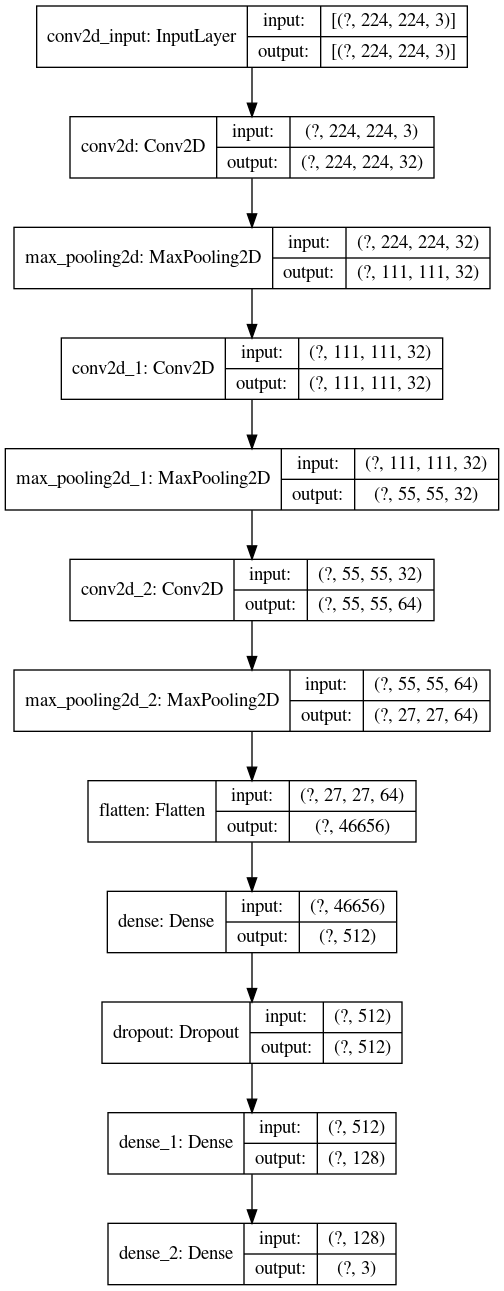

In [7]:
model = Sequential(name="SoilNet Model")
model.add(Conv2D(32,(5,5),padding="same",activation="relu",input_shape=(224,224,3)))
model.add(MaxPooling2D((3,3),strides=2))

model.add(Conv2D(32,(3,3),padding="same",activation="relu"))
model.add(MaxPooling2D((2,2),strides=2))

model.add(Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(MaxPooling2D((2,2),strides=2))

model.add(Flatten())
model.add(Dense(512,activation="relu"))
#model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(128,activation="relu"))
model.add(Dense(3,activation="softmax"))

optimizer = Adam(decay=1e-2,learning_rate=0.001)
model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()
plot_model(model,show_shapes=True)

Epoch 1/5
1/1 [==============================] - 11s 11s/step - loss: 1.1106 - accuracy: 0.2500 - val_loss: 2.8280 - val_accuracy: 0.2812
Epoch 2/5
1/1 [==============================] - 8s 8s/step - loss: 2.7034 - accuracy: 0.3125 - val_loss: 1.7995 - val_accuracy: 0.7188
Epoch 3/5
1/1 [==============================] - 7s 7s/step - loss: 1.6837 - accuracy: 0.4062 - val_loss: 1.4658 - val_accuracy: 0.6562
Epoch 4/5
1/1 [==============================] - 8s 8s/step - loss: 1.2853 - accuracy: 0.6250 - val_loss: 1.0758 - val_accuracy: 0.5000
Epoch 5/5
1/1 [==============================] - 8s 8s/step - loss: 1.1930 - accuracy: 0.4375 - val_loss: 0.8956 - val_accuracy: 0.5625
Total train time:  0.7133023977279663  mins


<Figure size 14400x7200 with 0 Axes>

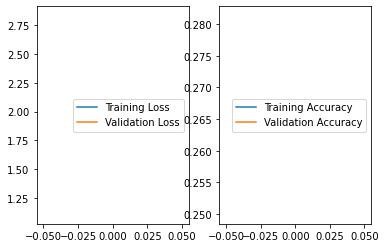

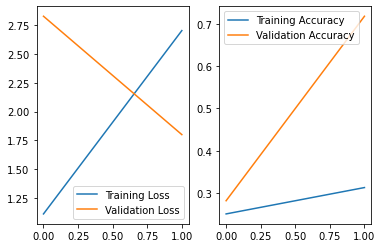

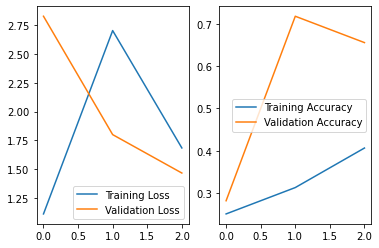

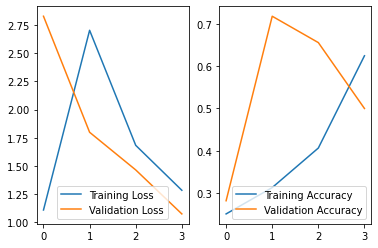

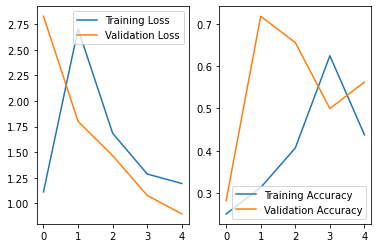

In [8]:
bot_callback = botCallback(access_token)
plotter = Plotter(access_token)
callback_list = [bot_callback,plotter]
start = time.time()

history = model.fit_generator(train_data,
                    steps_per_epoch = 5,
                    validation_data = test_data,
                    validation_steps = 5,
                    epochs=5,
                    callbacks=callback_list)
end = time.time()
print("Total train time: ",(end-start)/60," mins")

In [9]:
def plot_graph(history,string):
    plt.figure(figsize=(12,8))
    plt.plot(history.history[string],label=str(string))
    plt.plot(history.history["val_"+str(string)],label="val_"+str(string))
    plt.xlabel("Epochs")
    plt.ylabel(str(string))
    plt.show()


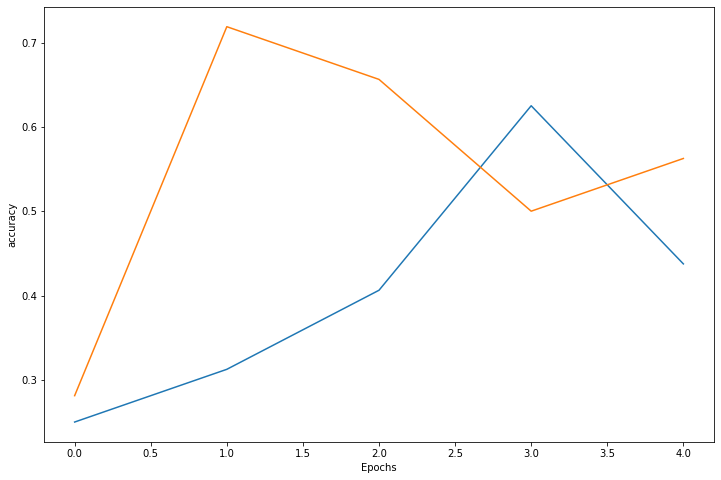

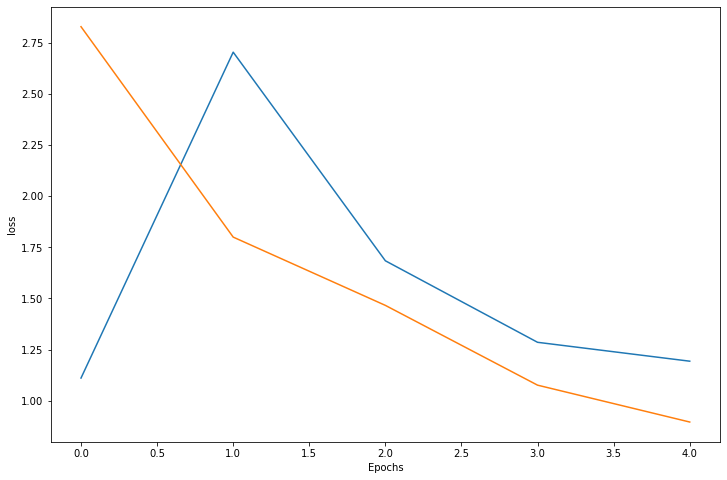

In [10]:
plot_graph(history,"accuracy")
plot_graph(history,"loss")

In [11]:
model.save("Model.h5")

In [12]:
from IPython.display import FileLink
FileLink('Model.h5')

/kaggle/working/Model.h5